In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


C:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


C:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

experiments.2Q_state_tomography
experiments.amplitude_rabi
experiments.amplitude_rabi_ef
experiments.amplitude_rabi_EgGf
experiments.clifford_averager_program
experiments.fitting
experiments.length_rabi
experiments.length_rabi_EgGf
experiments.pulse_probe_ef_spectroscopy
experiments.pulse_probe_EgGf_spectroscopy
experiments.pulse_probe_spectroscopy
experiments.ramsey_ef
experiments.randbench
experiments.resonator_spectroscopy
experiments.rfsoc_tof_calibration
experiments.single_shot
experiments.t1
experiments.t2_echo
experiments.t2_ramsey


In [408]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [405]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\slab_rfsoc_expts\data


In [406]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\slab_rfsoc_expts\config_q3diamond.yml


In [407]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)

# Qubit/resonator to probe

In [433]:
qubit_i = 2

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [410]:
im = InstrumentManager()

In [8]:
lo1 = im[yaml_cfg['aliases']['readout_LO']]
lo1.open_device()
print(lo1.get_id())
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg['hw']['lo']['readout']['frequency'])) # Set LO frequency
lo1.set_power(float(yaml_cfg['hw']['lo']['readout']['power'])) # Set LO power

Default Instrument SC26C3


0

In [411]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# RFSoC Calibration

If the RFSoC is power cycled first run "dac-adc phase offset" calibration.

Run this calibration when the wiring of the setup is changed.

This calibration measures the time of flight of measurement pulse so we only start capturing data from this point in time onwards. Time of flight (tof) is stored in parameter <code>cfg.device.readout.trig_offset</code>.

In [315]:
pulse_length =      soc.us2cycles(9.9, gen_ch=6)
readout_length =    soc.us2cycles(9.9, ro_ch=0)
print(soc.cycles2us(95, gen_ch=6))
print(soc.cycles2us(95, ro_ch=0))
print(soc.us2cycles(soc.cycles2us(95, gen_ch=6), ro_ch=0))
print(pulse_length, readout_length, readout_length-pulse_length)

0.22088913690476192
0.3092447916666667
68
4258 3041 -1217


In [438]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1, # [us]
    readout_length=2, # [us]
    # pulse_length=2.9, # [us]
    # readout_length=2.9, # [us]
    trig_offset=0, # [clock ticks]
    gain=32000,
    # gain=0.9, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=100, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=1 # wait time between experiments [us]
print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 1}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', '

  0%|          | 0/100 [00:00<?, ?it/s]

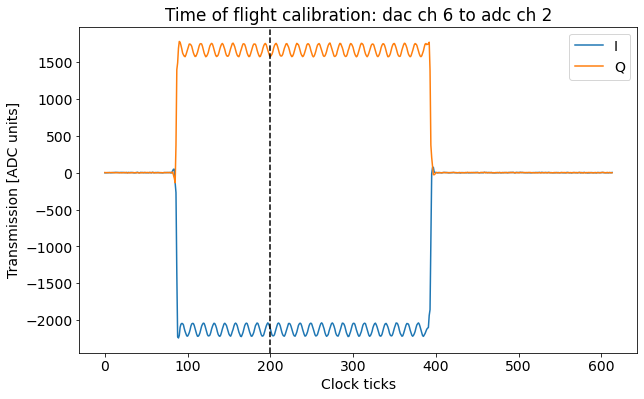

In [439]:
tof.display(adc_trig_offset=200)

In [131]:
tof.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_adc_trig_offset_calibration_qubit1.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [441]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 5 # MHz
npts = 5
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    # start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=1940,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=100, # Number averages per point
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain=250

rspec.cfg.device.readout.relax_delay=3 # Wait time between experiments [us]
rspec.cfg.device.readout.readout_length=1 # For some reason it doesn't like it when this is more than 1-2 [us]

print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': 1, 'relax_delay': 3}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 20

  0%|          | 0/5 [00:00<?, ?it/s]

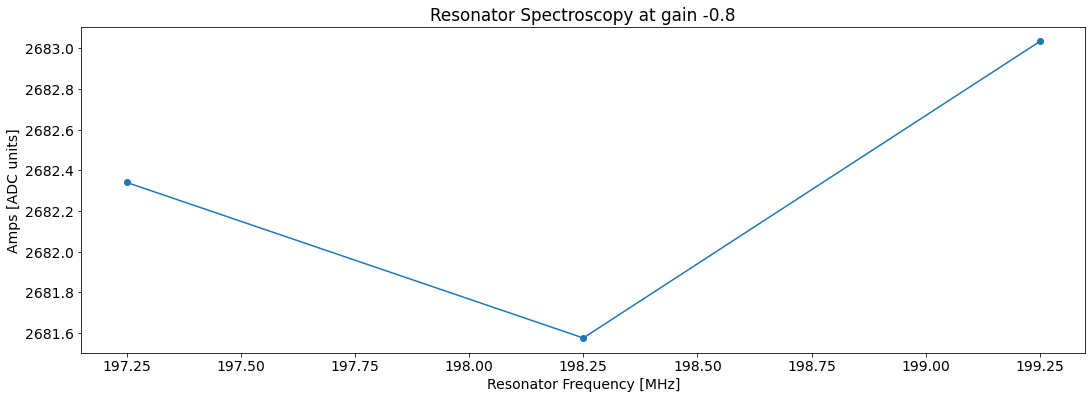

In [442]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=False, findpeaks=False)
rspec.display(fit=False, findpeaks=False)

In [96]:
rspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_resonator_spectroscopy_qubit1.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [6]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2.0
npts_f = 151

span_gain = 500
npts_gain = 50

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # Resonator frequency to be mixed up [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=5000, # Number averages per point
    pi_pulse=False, # add pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

NameError: name 'soc' is not defined

Extracted data and attrs ['config']


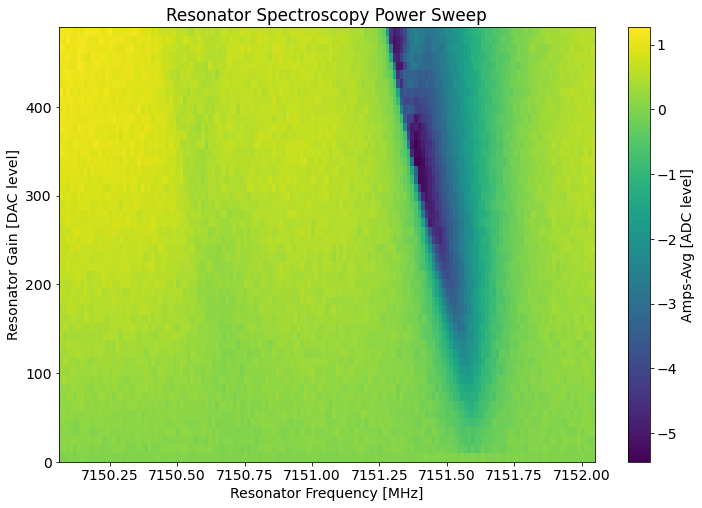

In [40]:
# TESTING
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
rpowspec.display(data=temp_data, fit=False)

# rpowspec.analyze(fit=False, lowgain=150, highgain=None)
# rpowspec.display(fit=False)

In [533]:
rpowspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_power_sweep_resonator_spectroscopy_qubit1.h5


## Voltage sweep resonator spectroscopy

In [285]:
rvoltspec = meas.ResonatorVoltSweepSpectroscopyExperiment(
    soccfg=soc,
    # dc_instr=arduino,
    dc_instr=yoko,
    path=expt_path,
    prefix=f"voltage_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 4
npts_f = 151

span_volt = 4e-3
npts_volt = 61

rvoltspec.cfg.expt = dict(
    dc_ch=qubit_to_dac[qubit_i],
    start_f=2055.5, #rvoltspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Resonator frequency to be mixed up [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_volt=-2e-3, #span_volt/2,
    step_volt=span_volt/npts_volt, # Gain step size
    expts_volt=npts_volt, # Number experiments stepping gain from start
    reps=3000, # Number averages per point
    pi_pulse=False, # add pi pulse before measurement
    qubit=qubit_i,
)
rvoltspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
rvoltspec.cfg.device.readout.readout_length=2 # For some reason it doesn't like it when this is more than 1-2 [us]

print(rvoltspec.cfg)

rvoltspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'dac': [0, 1, 2, 3], 'T1': [12, 28, 22, 22], 'f_ge': [4318.128165137126, 4200.120666612184, 4332.61700737276, 4235.7], 'dc_offset': [-0.0026, 0.00255, '2e-3', '5e-3'], 'pulses': {'pi_ge': {'gain': [11000, 11126, 21861, 32000], 'sigma': [0.2, 0.1, 0.1, 0.35], 'type': ['gauss', 'const', 'gauss', 'gauss']}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'dac': [0, 1, 2, 3], 'adc': [0, 1, 2, 3], 'lo': ['readout', 'readout', 'readout', 'readout'], 'trig_offset': 180, 'frequency': [1687.626826454077, 1821.7976311472094, 1943.3427763118934, 2058.56], 'gain': [70, 50, 60, 100], 'phase': [0, 0, 0, 0], 'readout_length': 2, 'relax_delay': 3}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 0, 0, 0]}}, 'dacs': {'qubit': {'ch': [5, 5, 5, 5], 'nyquist': [2, 2, 2, 2]}, 'readout': {'ch': [7, 7, 7, 7], 'nyquist': [1, 1, 1, 1]}}}}, 'aliases': {'readout_LO': 'SC_26C

current set to -2000.0 uA
current set to -1934.3999999999999 uA
current set to -1868.8000000000002 uA
current set to -1803.2 uA
current set to -1737.7 uA
current set to -1672.1 uA
current set to -1606.5 uA
current set to -1540.9 uA
current set to -1475.3999999999999 uA
current set to -1409.8 uA
current set to -1344.2 uA
current set to -1278.6 uA
current set to -1213.1 uA
current set to -1147.5 uA
current set to -1081.9 uA
current set to -1016.3 uA
current set to -950.8000000000001 uA
current set to -885.2 uA
current set to -819.6 uA
current set to -754.0 uA
current set to -688.5 uA
current set to -622.9 uA
current set to -557.3000000000001 uA
current set to -491.8 uA
current set to -426.2 uA
current set to -360.59999999999997 uA
current set to -295.0 uA
current set to -229.5 uA
current set to -163.9 uA
current set to -98.3 uA
current set to -32.7 uA
current set to 32.7 uA
current set to 98.3 uA
current set to 163.9 uA
current set to 229.5 uA
current set to 295.0 uA
current set to 360.5

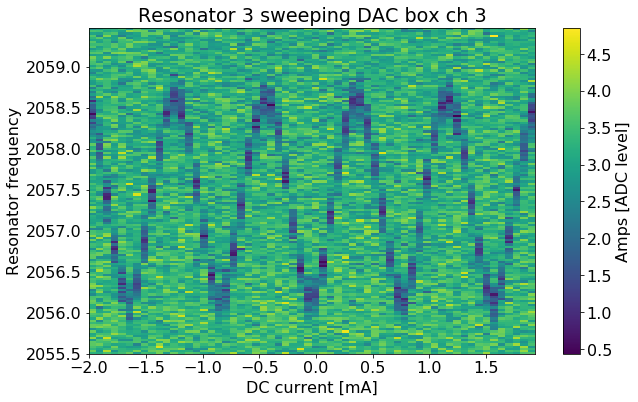

In [286]:
# TESTING
# temp_data, attrs = prev_data(expt_path, '00024_voltage_sweep_resonator_spectroscopy_qubit0.h5')
# add_data = []
# add_data.append(prev_data(expt_path, '00025_voltage_sweep_resonator_spectroscopy_qubit0.h5'))
# add_data.append(prev_data(expt_path, '00026_voltage_sweep_resonator_spectroscopy_qubit0.h5'))
# data = rvoltspec.analyze(data=temp_data)
# rvoltspec.display(data=temp_data, add_data=add_data)

rvoltspec.analyze()
rvoltspec.display()

In [287]:
rvoltspec.save_data()

Saving s:\Connie\experiments\20220222_LL_flux_crosstalk\data\00006_voltage_sweep_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [446]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2
npts = 15

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=3000,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=500, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=20, # Qubit probe constant pulse length [us]
    gain=100, # Qubit pulse gain
    qubit=qubit_i,
    # frequency=1821.6 #from res spec above
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time betwee n experiments [us]

print(qspec.cfg)

# arduino.set_voltage(channel=dc_ch, voltage=0.2)
qspec.go(analyze=False, display=False, progress=True, save=False)
# arduino.set_voltage(channel=dc_ch, voltage=0)

# qspec.analyze(fit=True)
# qspec.display(fit=True)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 

  0%|          | 0/10 [00:00<?, ?it/s]

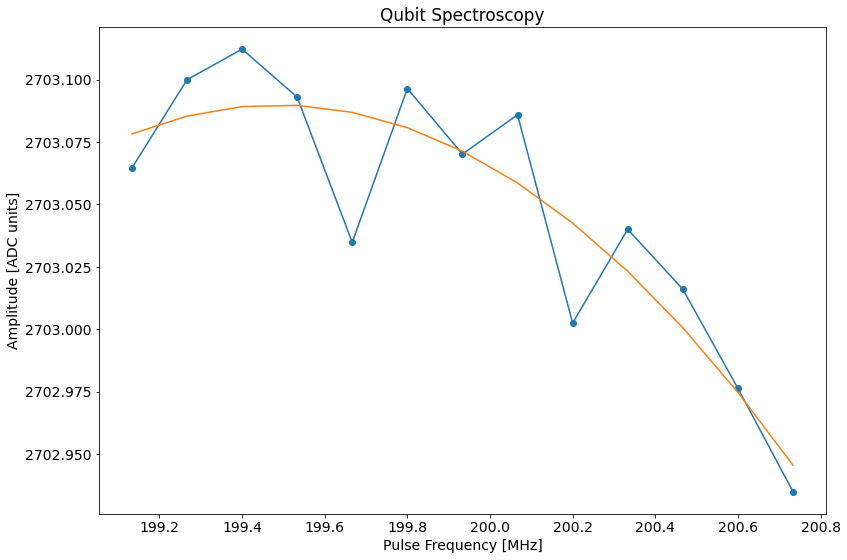

In [447]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True)
qspec.display(fit=True)

In [540]:
qspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_qubit_spectroscopy_qubit1.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [449]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(5), # pulse length (sigma) [us]
    step=soc.cycles2us(5), # [us]
    # step=0.001,
    expts=15,
    reps=50,
    gain=32000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 100}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4',

  0%|          | 0/15 [00:00<?, ?it/s]

Pi length from avgi data [us]: 0.02816758463452052
Pi/2 length from avgi data [dac units]: 0.01408379231726026
Pi length from avgq data [us]: 0.026295433784140555
Pi/2 length from avgq data [dac units]: 0.013147716892070277


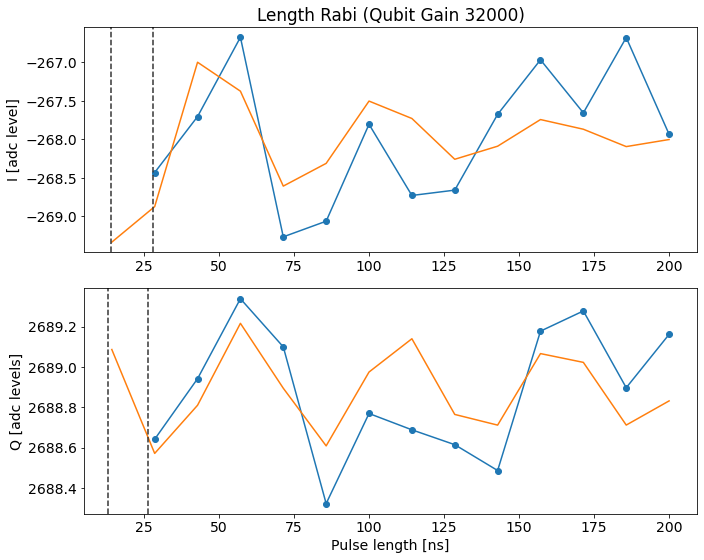

In [450]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [625]:
lengthrabi.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_length_rabi_qubit0.h5


## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [451]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 121
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=20,
    rounds=5,
    sigma_test=0.300, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabi.cfg)

amprabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 50}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 

  0%|          | 0/5 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 16248
	Pi/2 gain from avgi data [dac units]: 8124
Pi gain from avgq data [dac units]: 40420
	Pi/2 gain from avgq data [dac units]: 20210


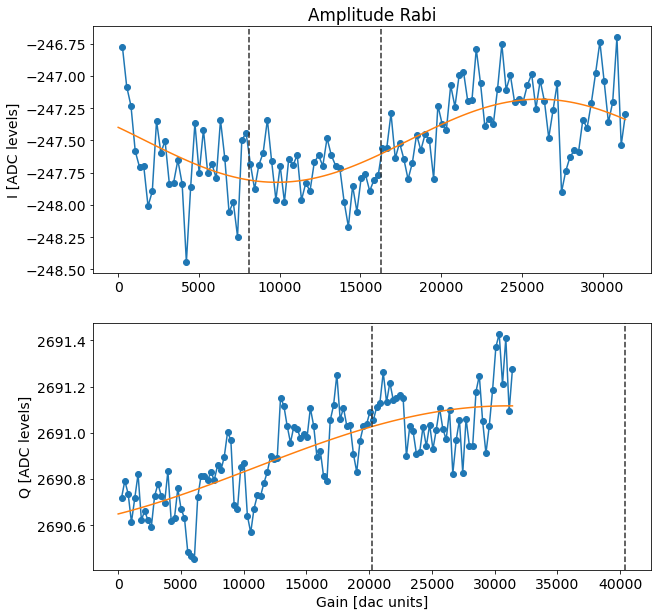

In [452]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_amp_rabi_qubit1.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [628]:
amprabi.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_amp_rabi_qubit0.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 3

span_f = 5
npts_f = 5

amprabichev.cfg.expt = dict(
    start_f=4315,
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [454]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=1751.5253727591987 
# shot.cfg.device.readout.gain=270
# shot.cfg.device.readout.readout_length = 16 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10000 [00:00<?, ?it/s]

6145


  0%|          | 0/10000 [00:00<?, ?it/s]

Ig -40.47241659886086 +/- 1.5205986666765108 	 Qg 2701.7357200976403 +/- 1.429518714512639
Ie -39.26061838893409 +/- 1.2965994946879715 	 Qe 2702.7825061025223 +/- 0.6712565035329406
Ig -40.47241659886086 +/- 1.5205986666765108 	 Qg 2701.7357200976403 +/- 1.429518714512639
Ie -39.26061838893409 +/- 1.2965994946879715 	 Qe 2702.7825061025223 +/- 0.6712565035329406
fidelity: 0.47992399619980997
rotation angle (deg): -40.82139353049898
set angle to (deg): 40.82139353049898
threshold: 1735.9323653103247


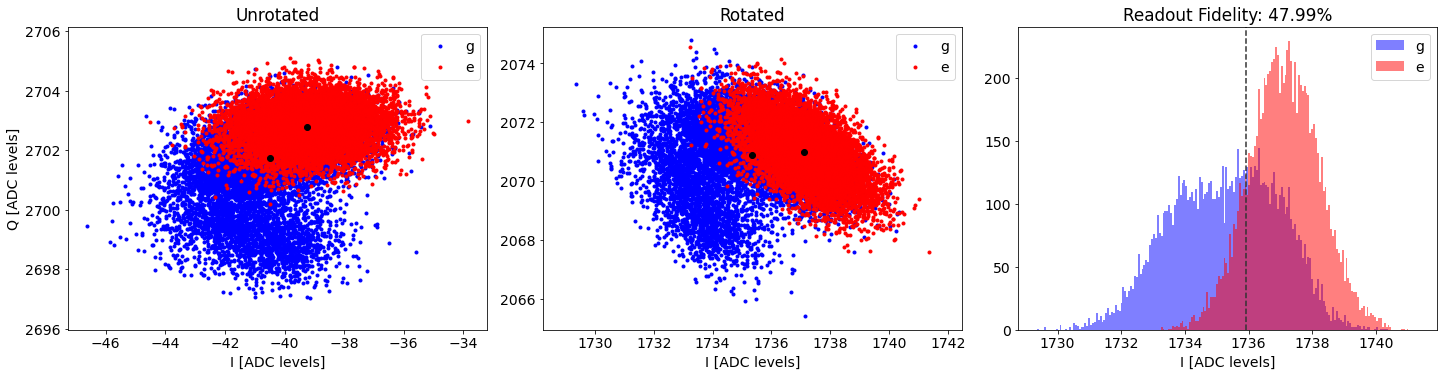

In [455]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze()
shot.display()

In [89]:
shot.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_qubit0.h5


### Single shot optimization

In [91]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2 # MHz
npts_f = 8

span_gain = 140
# npts_gain = 2
npts_gain = 7

span_len = 15 # us
# npts_len = 2
npts_len = 5

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=150,
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 35], 'T2R': [13, 20], 'f_ge': [3646.7584779001595, 4536.33065792081], 'f_ef': [3487.35, 4354.3124984175265], 'f_EgGf': 5243.181945338396, 'pulses': {'pi_ge': {'gain': [29284, 2154], 'sigma': [0.3, 0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [24292, 3586], 'sigma': [0.5, 0.02], 'type': 'gauss'}, 'pi_EgGf': {'gain': 15170, 'sigma': 0.4, 'type': 'gauss'}}}, 'readout': {'trig_offset': 180, 'frequency': [552.2, 1751.5253727591987], 'gain': [94, 255], 'phase': [-0.21743215294427692, -3.095165520548619], 'threshold': [72.01127819598226, -2.544007934071093], 'readout_length': [13, 22], 'relax_delay': [200, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5.4e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [3, 1], 'nyquist': [2, 2]}, 'swap': {'ch': 1, 'nyquist': 2}, 'readout': {'ch': [0, 4], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick186'}, 'expt': {'reps': 100000, 'qubit': 1, 'start_f': 1750.025

  0%|          | 0/8 [00:00<?, ?it/s]

In [116]:
shotopt.analyze()
print(shotopt.data['fid'])

(6, 6, 2)
[1750.02537276 1750.27537276 1750.52537276 1750.77537276 1751.02537276
 1751.27537276 1751.52537276 1751.77537276]
[150 170 190 210 230 250 270]
[10. 13. 16. 19. 22.]
Max fidelity 0.23594589864746618
Set params: 
 angle (deg) -4.944448307509958 
 threshold 3.277441669013662 
 freq [Mhz] 1751.5253727591987 
 gain [dac units] 270 
 readout length [us] 16.0
[[[0.01682008 0.01341007 0.01126006 0.01101006 0.01490007]
  [0.01511008 0.01690008 0.01728017 0.01579008 0.01560016]
  [0.01468015 0.01793009 0.01799009 0.01894009 0.0198303 ]
  [0.0196801  0.02366012 0.01772009 0.02299011 0.01835009]
  [0.01798009 0.0193801  0.02228011 0.02124011 0.0196401 ]
  [0.0201102  0.02239011 0.02387024 0.02159011 0.02301012]
  [0.02533013 0.02573039 0.02566026 0.02456025 0.02144011]]

 [[0.02697013 0.02618013 0.02557013 0.02589039 0.02283011]
  [0.02641013 0.02903015 0.02653013 0.02713014 0.02934015]
  [0.03406034 0.03354017 0.02885014 0.03038015 0.02783014]
  [0.03447052 0.0401702  0.03671018 0.038

In [93]:
shotopt.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [457]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 200
npts = 15

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=20,
    rounds=20,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = 200 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 200}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4',

  0%|          | 0/20 [00:00<?, ?it/s]

Fit T1 [us]: 81.6002654331817


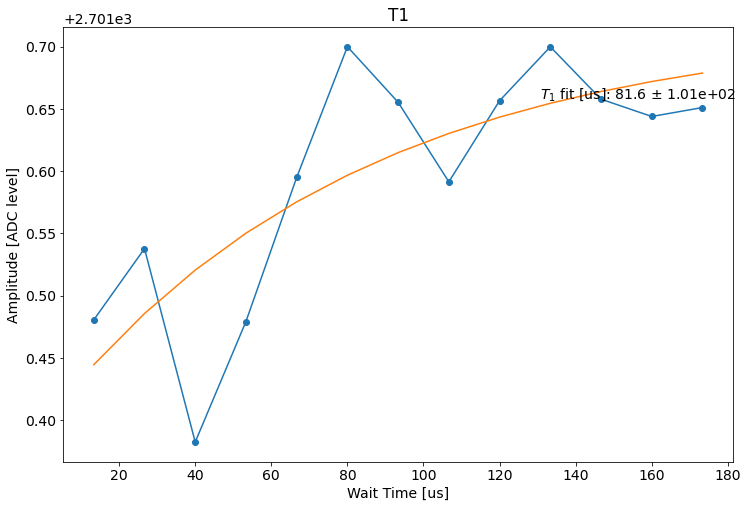

In [458]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [646]:
t1.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_t1_qubit0.h5


## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [591]:
0.5/soc.cycles2us(50)

3.84

In [459]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=15,
    ramsey_freq=1, # [MHz]
    reps=10,
    rounds=20,
    qubit=qubit_i,
)

t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2r.cfg)

t2r.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 150}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4',

  0%|          | 0/20 [00:00<?, ?it/s]

Fit frequency from amps [MHz]: 10.386974398759303
Suggested new qubit frequencies from fit amps [MHz]:
 	190.6130256012407
 	188.6130256012407
T2 Ramsey from fit amps [us]: 3112.40848221015


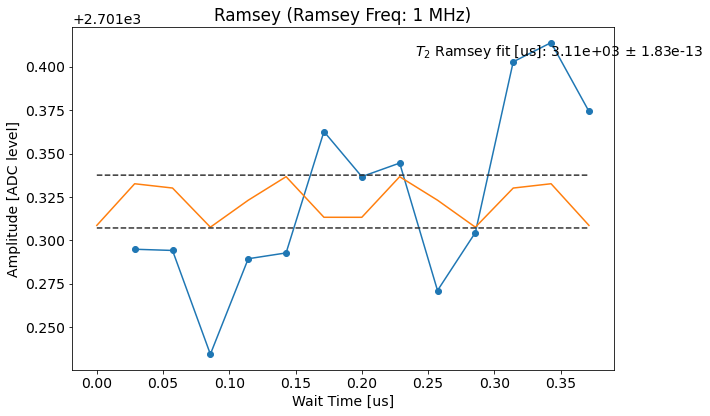

In [460]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True)
t2r.display(fit=True)

In [652]:
t2r.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_ramsey_qubit0.h5


## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [117]:
soc.us2cycles(0.005)

2

In [462]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(10), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=15,
    ramsey_freq=1, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=500,
    rounds=20,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': 150}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4',

  0%|          | 0/20 [00:00<?, ?it/s]

Fit frequency from amps [MHz]: 9.066363339008255
Suggested new qubit frequency from fit amps [MHz]: 191.93363666099174
T2 Echo from fit amps [us]: 182.35782171452595


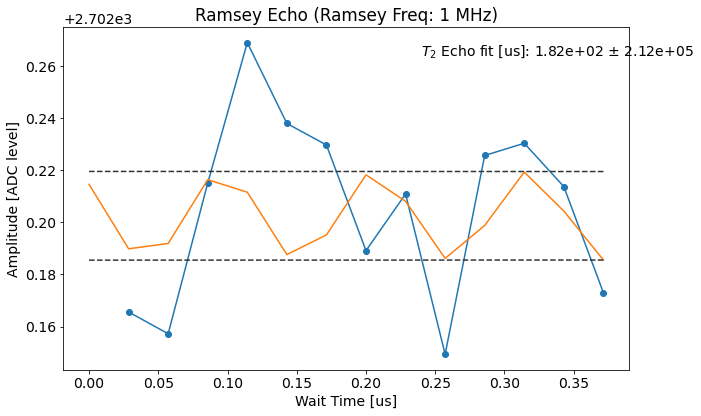

In [463]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [655]:
t2e.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_echo_qubit0.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [464]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 100
npts = 15

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=20, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=15, # ef probe constant pulse length [us]
    gain=1000, # ef pulse gain
    qubit=qubit_i,
)

print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi at [MHz] 156.6982270386672, HWHM 0.04095769119652787
Found peak in avgq at [MHz] 203.33364534413107, HWHM 0.003605589893713873


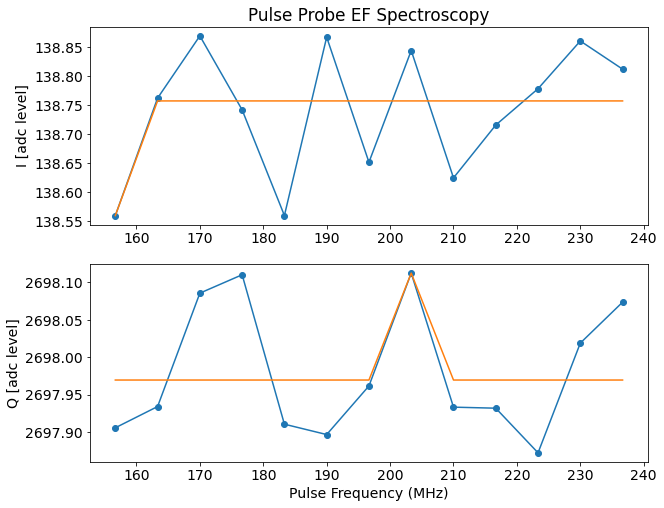

In [465]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True)
qEFspec.display(fit=True)

In [29]:
qEFspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_qubit_EF_spectroscopy_qubit1.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

In [ ]:
rpowspec.save_data()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [466]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 10000
npts = 15

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=20,
    rounds=10,
    sigma_test=0.02, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 1588
	Pi/2 gain from avgi data [dac units]: 794
Pi gain from avgq data [dac units]: 1895
	Pi/2 gain from avgq data [dac units]: 947


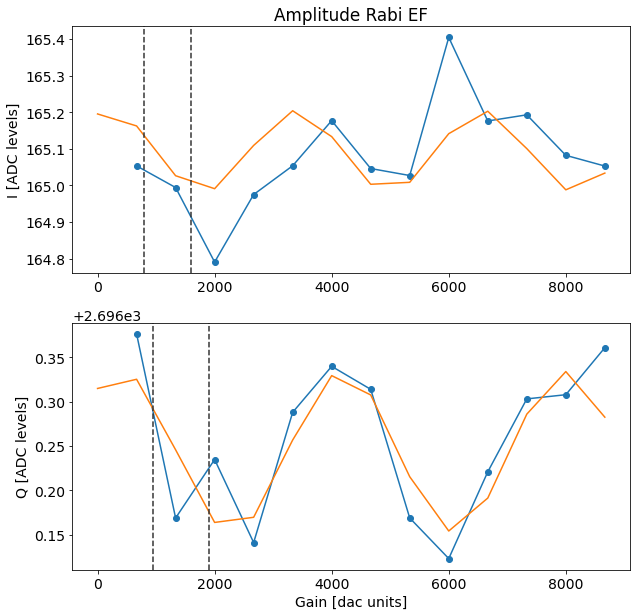

In [467]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [34]:
amprabiEF.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_amp_rabi_EF_qubit1.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [468]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=15,
    ramsey_freq=1.5, # [MHz]
    reps=20,
    rounds=20,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/20 [00:00<?, ?it/s]

Fit frequency from amps [MHz]: 8.935718332550108
Suggested new EF frequencies from fit amps [MHz]:
 	192.5642816674499
 	189.5642816674499
T2 Ramsey EF from fit amps [us]: 0.2038612082168112


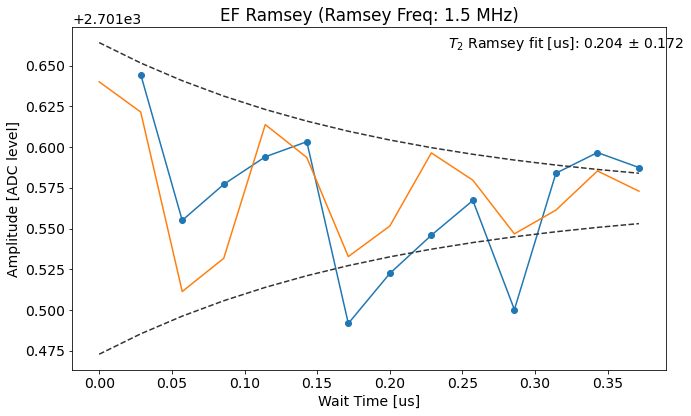

In [469]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [42]:
t2EFr.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_ramseyEF_qubit1.h5
